<a href="https://colab.research.google.com/github/mildsupitcha25/MachineLearning_phishing_email/blob/main/ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#XGBoost

In [ ]:
# ==============================
# 1. Import Libraries
# ==============================
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier

# ==============================
# 2. Load Data
# ==============================
TRAIN_URL = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/train.csv'
TEST_URL = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/test_global_unique.csv'

print("กำลังโหลดข้อมูลจาก GitHub...")
try:
    train_df = pd.read_csv(TRAIN_URL)
    test_df = pd.read_csv(TEST_URL)
    print("โหลดข้อมูลสำเร็จ!")
except Exception as e:
    print(f"เกิดข้อผิดพลาดในการโหลดข้อมูล: {e}")
    exit()

print(f"Train Shape: {train_df.shape}")
print(f"Test Shape: {test_df.shape}")
print(f"Train Columns: {list(train_df.columns)}")

# ==============================
# 3. Data Preparation
# ==============================
train_df['FullText'] = train_df['Subject'].fillna('') + ' ' + train_df['Body'].fillna('')
test_df['FullText'] = test_df['Subject'].fillna('') + ' ' + test_df['Body'].fillna('')

TEXT_COLUMN = 'FullText'
TARGET_COLUMN_STR = 'Label'

label_mapping = {'Legitimate': 0, 'Phishing': 1}
train_df['label_num'] = train_df[TARGET_COLUMN_STR].map(label_mapping)

X_train = train_df[TEXT_COLUMN].fillna('')
y_train = train_df['label_num']
X_test = test_df[TEXT_COLUMN].fillna('')

# ==============================
# 4. TF-IDF Vectorization
# ==============================
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f"TF-IDF Train Shape: {X_train_vec.shape}")

# ==============================
# 5. Train/Validation Split
# ==============================
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_vec, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# ==============================
# 6. Hyperparameter Tuning (RandomizedSearchCV)
# ==============================
param_dist = {
    'n_estimators': [200, 500, 800, 1000],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20,              # จำนวนรอบสุ่ม
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

print("\nกำลังทำ Hyperparameter Tuning ด้วย RandomizedSearchCV...")
random_search.fit(X_train_split, y_train_split)

best_xgb_model = random_search.best_estimator_
print("\nBest Parameters:", random_search.best_params_)

# ==============================
# 7. Evaluate Model
# ==============================
y_val_pred = best_xgb_model.predict(X_val_split)
print("\nValidation Accuracy:", accuracy_score(y_val_split, y_val_pred))
print(classification_report(y_val_split, y_val_pred))

# ==============================
# 8. Predict Test Set
# ==============================
y_pred = best_xgb_model.predict(X_test_vec)

submission_df = test_df.copy()
submission_df['Predicted_Label_Num'] = y_pred
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
submission_df['Predicted_Label'] = submission_df['Predicted_Label_Num'].map(reverse_label_mapping)

# เลือกคอลัมน์สำหรับแสดงผล
if 'Id' in test_df.columns:
    output_cols = ['Id', 'Predicted_Label']
elif 'ID' in test_df.columns:
    output_cols = ['ID', 'Predicted_Label']
else:
    submission_df['Index'] = submission_df.index
    output_cols = ['Index', 'Predicted_Label']

final_submission = submission_df[output_cols]

# ✅ แสดงผลลัพธ์ตรง ๆ โดยไม่ดาวน์โหลดไฟล์
print("\n--- ผลลัพธ์การทำนาย (20 แถวแรก) ---")
print(final_submission.head(20))
print("\nจำนวนทั้งหมด:", len(final_submission))

กำลังโหลดข้อมูลจาก GitHub...
โหลดข้อมูลสำเร็จ!
Train Shape: (100, 3)
Test Shape: (100, 3)
Train Columns: ['Subject', 'Body', 'Label']
TF-IDF Train Shape: (100, 2616)

กำลังทำ Hyperparameter Tuning ด้วย RandomizedSearchCV...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best Parameters: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}

Validation Accuracy: 0.95
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.91      1.00      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20


--- ผลลัพธ์การทำนาย (20 แถวแรก) ---
    Index Predicted_Label
0       0        Phishing
1       1        Phishing
2       2        Phishing
3       3        Phishing
4       4        Phishing
5 

#Naive Bayes
+ SMOTE + Cross-validation + AUC/ROC + Predict Test Set


กำลังโหลดข้อมูล...
โหลดข้อมูลสำเร็จ!
Train Shape: (100, 3), Test Shape: (26, 3)
ก่อน SMOTE: {0: 40, 1: 40}
หลัง SMOTE: {0: 40, 1: 40}

Cross-Validation Accuracy: 0.9600 ± 0.0374
Cross-Validation AUC: 1.0000 ± 0.0000

[Validation Set]
Accuracy: 1.0
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00        10
    Phishing       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

AUC Score: 1.0000


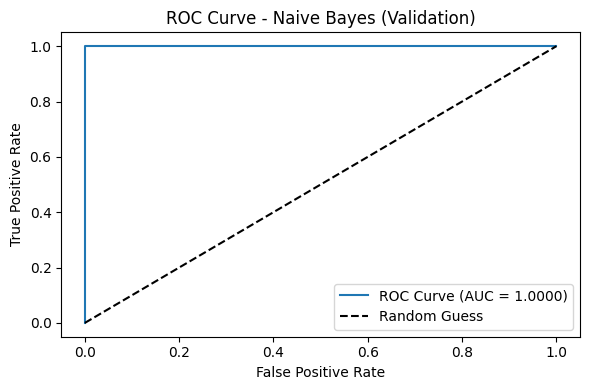


--- ผลลัพธ์การทำนาย Test Set (20 แถวแรก) ---
                                              Subject Predicted_Label  \
0   Exclusive Personal Relationship Opportunity Ju...      Legitimate   
1   Exceptional Work-From-Home Job Opportunity Awa...      Legitimate   
2   Notification of Recent Account Activity - Acti...      Legitimate   
3   Exciting Work-from-Home Job Opportunity: Immed...        Phishing   
4   Exclusive Promotional Offer Just for You, Lind...      Legitimate   
5   Exclusive Promotional Offer from "Dynamic Glob...        Phishing   
6   Exciting Job Opportunity Awaits You at [Organi...      Legitimate   
7   Fantastic Work-From-Home Opportunity at BellaN...      Legitimate   
8   Urgent Update Required for Your Health Managem...        Phishing   
9   Exciting Job Opportunity and Immediate Action ...      Legitimate   
10        Immediate Job Opportunity at Tech Solutions        Phishing   
11        Important Technical Update - Security Alert        Phishing   
12  I

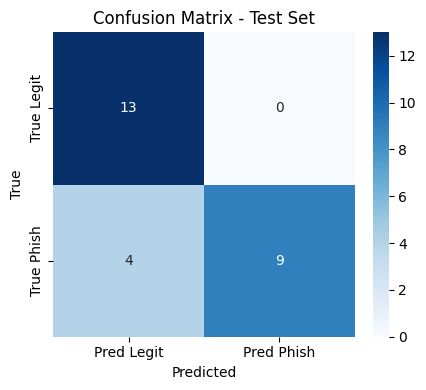


✅ บันทึกผลลัพธ์ในไฟล์: test_predictions_nb.csv


In [1]:
# ==============================
# 1. Import Libraries
# ==============================
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score, classification_report, roc_auc_score, roc_curve,
    confusion_matrix
)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')  # ✅ ปิด Warning

# ==============================
# 2. Load Data
# ==============================
TRAIN_URL = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/train.csv'
TEST_URL = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/test.csv'

print("\nกำลังโหลดข้อมูล...")
train_df = pd.read_csv(TRAIN_URL)
test_df = pd.read_csv(TEST_URL)
print("โหลดข้อมูลสำเร็จ!")
print(f"Train Shape: {train_df.shape}, Test Shape: {test_df.shape}")

# ตรวจสอบคอลัมน์ที่จำเป็น
required_cols = ['Subject', 'Body', 'Label']
missing_train = [c for c in required_cols if c not in train_df.columns]
missing_test_for_eval = [c for c in required_cols if c not in test_df.columns]

if missing_train:
    raise ValueError(f"Train file ขาดคอลัมน์: {missing_train}")
if missing_test_for_eval:
    print(f"⚠️ Test file ไม่มีคอลัมน์สำหรับประเมิน: {missing_test_for_eval}")
    print("โค้ดจะยังสามารถทำนาย test ได้ แต่จะไม่คำนวณ metrics เทียบกับ label จริงของ test set")

# ==============================
# 3. Data Preparation
# ==============================
# รวม Subject + Body เป็นฟีเจอร์ข้อความเดียว
train_df['FullText'] = train_df['Subject'].fillna('') + ' ' + train_df['Body'].fillna('')
test_df['FullText'] = test_df['Subject'].fillna('') + ' ' + test_df['Body'].fillna('')

# เข้ารหัส Label
label_mapping = {'Legitimate': 0, 'Phishing': 1}
train_df['label_num'] = train_df['Label'].map(label_mapping)

# ตรวจ Missing/Unmapped labels
if train_df['label_num'].isna().any():
    bad = train_df[train_df['label_num'].isna()]['Label'].unique()
    raise ValueError(f"พบ Label ใน train ที่ไม่รู้จัก: {bad}. โปรดอัปเดต label_mapping")

X = train_df['FullText']
y = train_df['label_num']
X_test = test_df['FullText']

# ถ้า test มี Label จริง ให้แมปด้วย
test_has_label = False
if 'Label' in test_df.columns:
    test_df['label_num'] = test_df['Label'].map(label_mapping)
    if test_df['label_num'].isna().any():
        bad = test_df[test_df['label_num'].isna()]['Label'].unique()
        raise ValueError(f"พบ Label ใน test ที่ไม่รู้จัก: {bad}. โปรดอัปเดต label_mapping")
    else:
        test_has_label = True

# ==============================
# 4. TF-IDF Vectorization
# ==============================
vectorizer = TfidfVectorizer(
    stop_words='english',
    lowercase=True,
    max_features=5000,
    ngram_range=(1, 2)
)
X_vec = vectorizer.fit_transform(X)        # fit บน train เท่านั้น
X_test_vec = vectorizer.transform(X_test)  # transform บน test

# ==============================
# 5. Train/Validation Split + SMOTE
# ==============================
X_train, X_val, y_train, y_val = train_test_split(
    X_vec, y, test_size=0.2, random_state=42, stratify=y
)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("ก่อน SMOTE:", y_train.value_counts().to_dict())
print("หลัง SMOTE:", pd.Series(y_train_resampled).value_counts().to_dict())

# ==============================
# 6. Cross-validation (Accuracy & AUC)
# ==============================
nb_model = MultinomialNB(alpha=0.5)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores = cross_val_score(nb_model, X_vec, y, cv=cv, scoring='accuracy')
auc_scores = cross_val_score(nb_model, X_vec, y, cv=cv, scoring='roc_auc')

print(f"\nCross-Validation Accuracy: {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}")
print(f"Cross-Validation AUC: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")

# ==============================
# 7. Train Final Model & ROC Curve (Validation)
# ==============================
nb_model.fit(X_train_resampled, y_train_resampled)
y_val_pred = nb_model.predict(X_val)
y_val_prob = nb_model.predict_proba(X_val)[:, 1]

print("\n[Validation Set]")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred, target_names=['Legitimate', 'Phishing']))

val_auc_score = roc_auc_score(y_val, y_val_prob)
print(f"AUC Score: {val_auc_score:.4f}")

fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {val_auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Naive Bayes (Validation)')
plt.legend()
plt.tight_layout()
plt.show()

# ==============================
# 8. Predict on Test Set + (Optional) Evaluate vs True Labels
# ==============================
y_test_prob = nb_model.predict_proba(X_test_vec)[:, 1]
y_test_pred = (y_test_prob >= 0.5).astype(int)  # ใช้ threshold 0.5 (ปรับได้)

test_df['Predicted_Label_Num'] = y_test_pred
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
test_df['Predicted_Label'] = test_df['Predicted_Label_Num'].map(reverse_label_mapping)
test_df['Predicted_Prob_Phishing'] = y_test_prob

print("\n--- ผลลัพธ์การทำนาย Test Set (20 แถวแรก) ---")
cols_show = ['Subject', 'Predicted_Label', 'Predicted_Prob_Phishing']
if test_has_label:
    cols_show += ['Label']
print(test_df[cols_show].head(20))

# ===== Evaluate on Test (ถ้ามี Label จริง) =====
if test_has_label:
    print("\n[Evaluation on TEST Set]")
    test_acc = accuracy_score(test_df['label_num'], y_test_pred)
    print(f"Test Accuracy: {test_acc:.4f}")

    print(classification_report(
        test_df['label_num'], y_test_pred, target_names=['Legitimate', 'Phishing']
    ))

    try:
        test_auc = roc_auc_score(test_df['label_num'], y_test_prob)
        print(f"Test AUC: {test_auc:.4f}")
    except ValueError:
        print("ไม่สามารถคำนวณ AUC ได้ (อาจเป็นเพราะมี class เดียวใน test)")

    # Confusion Matrix
    cm = confusion_matrix(test_df['label_num'], y_test_pred, labels=[0, 1])
    plt.figure(figsize=(4.5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred Legit', 'Pred Phish'],
                yticklabels=['True Legit', 'True Phish'])
    plt.title('Confusion Matrix - Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ Test set ไม่มี Label จริง จึงประเมิน metrics ไม่ได้")

# ==============================
# 9. Save Outputs
# ==============================
# ไฟล์ผลลัพธ์การทำนาย (รวม prob)
out_cols = ['Subject', 'Predicted_Label', 'Predicted_Prob_Phishing']
if test_has_label:
    out_cols = ['Subject', 'Label', 'Predicted_Label', 'Predicted_Prob_Phishing']
test_df[out_cols].to_csv('test_predictions_nb.csv', index=False)
print("\n✅ บันทึกผลลัพธ์ในไฟล์: test_predictions_nb.csv")

#Random forest เทียบกับ test set จริง

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, chi2

# ✅ URLs ของไฟล์ Train และ Test
TRAIN_URL = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/train.csv'
TEST_URL = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/test.csv'  # ใช้ไฟล์ที่คุณดาวน์โหลดมา

# --- 1. โหลดข้อมูล ---
train_df = pd.read_csv(TRAIN_URL)
test_df = pd.read_csv(TEST_URL)

# ✅ เตรียมข้อมูล Train
train_df['FullText'] = train_df['Subject'].fillna('') + ' ' + train_df['Body'].fillna('')
label_mapping = {'Legitimate': 0, 'Phishing': 1}
train_df['Label_num'] = train_df['Label'].map(label_mapping)

X = train_df['FullText']
y = train_df['Label_num']

# ✅ เตรียมข้อมูล Test
X_test = test_df['Subject'].fillna('') + ' ' + test_df['Body'].fillna('')
y_test_true = test_df['Label'].map(label_mapping)

# --- 2. TF-IDF ---
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, ngram_range=(1,2), max_features=5000)
X_vec = vectorizer.fit_transform(X)
X_test_vec = vectorizer.transform(X_test)

# --- 3. Feature Selection ---
selector = SelectKBest(chi2, k=2000)
X_sel = selector.fit_transform(X_vec, y)
X_test_sel = selector.transform(X_test_vec)

# --- 4. Train/Test Split สำหรับ Validation ---
X_train, X_val, y_train, y_val = train_test_split(X_sel, y, test_size=0.2, random_state=42, stratify=y)

# --- 5. โมเดล RandomForest ---
rf_model = RandomForestClassifier(n_estimators=300, max_depth=None, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# --- 6. ประเมินผลบน Validation ---
y_val_pred = rf_model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred))

# --- 7. ทำนายบน Test Set ---
y_test_pred = rf_model.predict(X_test_sel)

# ✅ คำนวณ Accuracy บน Test Set
print("\nTest Set Accuracy:", accuracy_score(y_test_true, y_test_pred))
print("\nConfusion Matrix (Test Set):\n", confusion_matrix(y_test_true, y_test_pred))
print("\nClassification Report (Test Set):\n", classification_report(y_test_true, y_test_pred, target_names=['Legitimate','Phishing']))

# ✅ แสดงผล 20 แถวแรกพร้อม Label จริง
test_df['Predicted_Label'] = ['Legitimate' if p == 0 else 'Phishing' for p in y_test_pred]
print("\n--- ผลลัพธ์การทำนาย Test Set (20 แถวแรก) ---")
print(test_df[['Subject','Label','Predicted_Label']].head(20))

# ✅ บันทึกผลลัพธ์
test_df[['Subject','Label','Predicted_Label']].to_csv('test_predictions_rf.csv', index=False)
print("\n✅ บันทึกผลลัพธ์ในไฟล์: test_predictions_rf.csv")


Validation Accuracy: 1.0

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20


Test Set Accuracy: 0.9230769230769231

Confusion Matrix (Test Set):
 [[13  0]
 [ 2 11]]

Classification Report (Test Set):
               precision    recall  f1-score   support

  Legitimate       0.87      1.00      0.93        13
    Phishing       1.00      0.85      0.92        13

    accuracy                           0.92        26
   macro avg       0.93      0.92      0.92        26
weighted avg       0.93      0.92      0.92        26


--- ผลลัพธ์การทำนาย Test Set (20 แถวแรก) ---
                                              Subject       Label  \
0   Exclusive Personal Relationship Opportuni

#CatBoost

In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.3 MB/s eta 0:00:00


In [ ]:
# ==============================
# 1. Import Libraries
# ==============================
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from catboost import CatBoostClassifier

# ==============================
# 2. Load Data
# ==============================
TRAIN_URL = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/train.csv'
TEST_URL = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/test_global_unique.csv'

print("กำลังโหลดข้อมูลจาก GitHub...")
train_df = pd.read_csv(TRAIN_URL)
test_df = pd.read_csv(TEST_URL)
print("โหลดข้อมูลสำเร็จ!")

print(f"Train Shape: {train_df.shape}")
print(f"Test Shape: {test_df.shape}")

# ==============================
# 3. Data Preparation
# ==============================
train_df['FullText'] = train_df['Subject'].fillna('') + ' ' + train_df['Body'].fillna('')
test_df['FullText'] = test_df['Subject'].fillna('') + ' ' + test_df['Body'].fillna('')

label_mapping = {'Legitimate': 0, 'Phishing': 1}
train_df['label_num'] = train_df['Label'].map(label_mapping)

X_train = train_df['FullText'].fillna('')
y_train = train_df['label_num']
X_test = test_df['FullText'].fillna('')

# ==============================
# 4. TF-IDF Vectorization
# ==============================
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f"TF-IDF Train Shape: {X_train_vec.shape}")

# ==============================
# 5. Train/Validation Split
# ==============================
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_vec, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# ==============================
# 6. CatBoost Model Training
# ==============================
cat_model = CatBoostClassifier(
    iterations=5,          # จำนวนรอบการเรียนรู้
    learning_rate=0.05,      # อัตราการเรียนรู้
    depth=5,                 # ความลึกของต้นไม้
    loss_function='Logloss', # ใช้สำหรับ classification
    eval_metric='Accuracy',
    random_seed=42,
    verbose=1             # แสดงผลทุก 100 รอบ
)

print("\nกำลังฝึกสอนโมเดล CatBoost...")
cat_model.fit(X_train_split, y_train_split, eval_set=(X_val_split, y_val_split))
print("ฝึกสอนเสร็จสิ้น!")

# ==============================
# 7. Evaluate Model
# ==============================
y_val_pred = cat_model.predict(X_val_split)
print("\nValidation Accuracy:", accuracy_score(y_val_split, y_val_pred))
print(classification_report(y_val_split, y_val_pred))

# ==============================
# 8. Predict Test Set
# ==============================
y_pred = cat_model.predict(X_test_vec)

submission_df = test_df.copy()
submission_df['Predicted_Label_Num'] = y_pred
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
submission_df['Predicted_Label'] = submission_df['Predicted_Label_Num'].map(reverse_label_mapping)

# เลือกคอลัมน์สำหรับแสดงผล
if 'Id' in test_df.columns:
    output_cols = ['Id', 'Predicted_Label']
elif 'ID' in test_df.columns:
    output_cols = ['ID', 'Predicted_Label']
else:
    submission_df['Index'] = submission_df.index
    output_cols = ['Index', 'Predicted_Label']

final_submission = submission_df[output_cols]

# ✅ แสดงผลลัพธ์ตรง ๆ โดยไม่ดาวน์โหลดไฟล์
print("\n--- ผลลัพธ์การทำนาย (20 แถวแรก) ---")
print(final_submission.head(20))
print("\nจำนวนทั้งหมด:", len(final_submission))



กำลังโหลดข้อมูลจาก GitHub...
โหลดข้อมูลสำเร็จ!
Train Shape: (100, 3)
Test Shape: (100, 3)
TF-IDF Train Shape: (100, 2616)

กำลังฝึกสอนโมเดล CatBoost...
0:	learn: 0.9375000	test: 1.0000000	best: 1.0000000 (0)	total: 44.4ms	remaining: 178ms
1:	learn: 0.9625000	test: 1.0000000	best: 1.0000000 (0)	total: 95.8ms	remaining: 144ms
2:	learn: 0.9750000	test: 0.9500000	best: 1.0000000 (0)	total: 147ms	remaining: 98.2ms
3:	learn: 0.9750000	test: 1.0000000	best: 1.0000000 (0)	total: 172ms	remaining: 42.9ms
4:	learn: 0.9750000	test: 0.9500000	best: 1.0000000 (0)	total: 204ms	remaining: 0us

bestTest = 1
bestIteration = 0

Shrink model to first 1 iterations.
ฝึกสอนเสร็จสิ้น!

Validation Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.0

#Logistic

กำลังโหลดข้อมูลจาก GitHub...
โหลดข้อมูลสำเร็จ!
Train Shape: (100, 3)
Test Shape: (100, 3)
TF-IDF Train Shape: (100, 2616)

กำลังฝึกสอนโมเดล Logistic Regression...
ฝึกสอนเสร็จสิ้น!

Validation Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



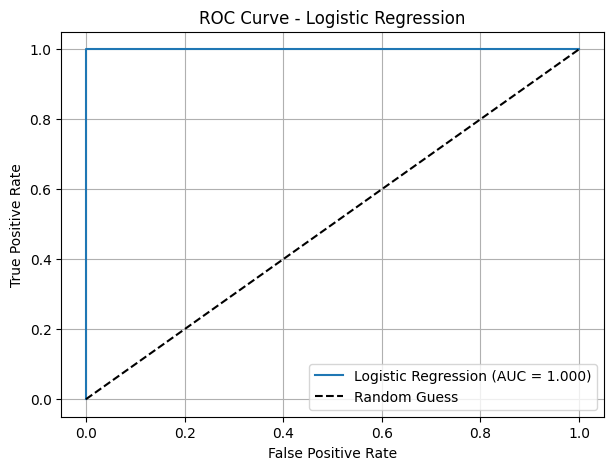


--- ผลลัพธ์การทำนาย (20 แถวแรก) ---
    Index Predicted_Label
0       0      Legitimate
1       1        Phishing
2       2        Phishing
3       3        Phishing
4       4        Phishing
5       5        Phishing
6       6        Phishing
7       7        Phishing
8       8        Phishing
9       9        Phishing
10     10        Phishing
11     11        Phishing
12     12        Phishing
13     13        Phishing
14     14        Phishing
15     15        Phishing
16     16        Phishing
17     17        Phishing
18     18      Legitimate
19     19        Phishing

จำนวนทั้งหมด: 100


In [ ]:

# ==============================
# 1. Import Libraries
# ==============================
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
   accuracy_score,
   classification_report,
   roc_curve,
   roc_auc_score
)
import matplotlib.pyplot as plt
# ==============================
# 2. Load Data
# ==============================
TRAIN_URL = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/train.csv'
TEST_URL = 'https://raw.githubusercontent.com/mildsupitcha25/MachineLearning_phishing_email/main/test_global_unique.csv'
print("กำลังโหลดข้อมูลจาก GitHub...")
train_df = pd.read_csv(TRAIN_URL)
test_df = pd.read_csv(TEST_URL)
print("โหลดข้อมูลสำเร็จ!")
print(f"Train Shape: {train_df.shape}")
print(f"Test Shape: {test_df.shape}")
# ==============================
# 3. Data Preparation
# ==============================
train_df['FullText'] = train_df['Subject'].fillna('') + ' ' + train_df['Body'].fillna('')
test_df['FullText'] = test_df['Subject'].fillna('') + ' ' + test_df['Body'].fillna('')
label_mapping = {'Legitimate': 0, 'Phishing': 1}
train_df['label_num'] = train_df['Label'].map(label_mapping)
X_train = train_df['FullText'].fillna('')
y_train = train_df['label_num']
X_test = test_df['FullText'].fillna('')
# ==============================
# 4. TF-IDF Vectorization
# ==============================
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
print(f"TF-IDF Train Shape: {X_train_vec.shape}")
# ==============================
# 5. Train/Validation Split
# ==============================
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
   X_train_vec, y_train, test_size=0.2, random_state=42, stratify=y_train
)
# ==============================
# 6. Logistic Regression Model Training
# ==============================
log_model = LogisticRegression(
   C=1.0,
   solver='liblinear',
   random_state=42,
   max_iter=1000
)
print("\nกำลังฝึกสอนโมเดล Logistic Regression...")
log_model.fit(X_train_split, y_train_split)
print("ฝึกสอนเสร็จสิ้น!")
# ==============================
# 7. Evaluate Model
# ==============================
y_val_pred = log_model.predict(X_val_split)
y_val_prob = log_model.predict_proba(X_val_split)[:, 1]  # สำหรับ ROC AUC
# ความแม่นยำและรายงานการจำแนก
print("\nValidation Accuracy:", accuracy_score(y_val_split, y_val_pred))
print(classification_report(y_val_split, y_val_pred))
# ==============================
# 8. ROC Curve & AUC Score
# ==============================
fpr, tpr, thresholds = roc_curve(y_val_split, y_val_prob)
auc_score = roc_auc_score(y_val_split, y_val_prob)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
# ==============================
# 9. Predict Test Set
# ==============================
y_pred = log_model.predict(X_test_vec)
submission_df = test_df.copy()
submission_df['Predicted_Label_Num'] = y_pred
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
submission_df['Predicted_Label'] = submission_df['Predicted_Label_Num'].map(reverse_label_mapping)
# เลือกคอลัมน์สำหรับแสดงผล
if 'Id' in test_df.columns:
   output_cols = ['Id', 'Predicted_Label']
elif 'ID' in test_df.columns:
   output_cols = ['ID', 'Predicted_Label']
else:
   submission_df['Index'] = submission_df.index
   output_cols = ['Index', 'Predicted_Label']
final_submission = submission_df[output_cols]
# ✅ แสดงผลลัพธ์ตรง ๆ โดยไม่ดาวน์โหลดไฟล์
print("\n--- ผลลัพธ์การทำนาย (20 แถวแรก) ---")
print(final_submission.head(20))
print("\nจำนวนทั้งหมด:", len(final_submission))